In [1]:
import numpy as np

In [2]:
np.random.seed(21)

In [3]:
from collections import defaultdict
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [5]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(512, 512, 3))

In [6]:
for l in base_model.layers:
    print(l.name, l.output_shape)

input_1 (None, 512, 512, 3)
block1_conv1 (None, 512, 512, 64)
block1_conv2 (None, 512, 512, 64)
block1_pool (None, 256, 256, 64)
block2_conv1 (None, 256, 256, 128)
block2_conv2 (None, 256, 256, 128)
block2_pool (None, 128, 128, 128)
block3_conv1 (None, 128, 128, 256)
block3_conv2 (None, 128, 128, 256)
block3_conv3 (None, 128, 128, 256)
block3_pool (None, 64, 64, 256)
block4_conv1 (None, 64, 64, 512)
block4_conv2 (None, 64, 64, 512)
block4_conv3 (None, 64, 64, 512)
block4_pool (None, 32, 32, 512)
block5_conv1 (None, 32, 32, 512)
block5_conv2 (None, 32, 32, 512)
block5_conv3 (None, 32, 32, 512)
block5_pool (None, 16, 16, 512)


In [7]:
base_model.get_layer(name="block5_conv3")

In [8]:
def get_unet(vgg16):
    # Up block 6
    b4 = vgg16.get_layer(name="block4_conv3").output # size 64x64
    b5 = vgg16.get_layer(name="block5_conv3").output # size 32x32
    up6 = concatenate([UpSampling2D(size=(2, 2), name='up_b5')(b5), b4], axis=-1, name='concat_up6')
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', name='up6_conv1')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', name='up6_conv2')(conv6)
    
    # Up block 7
    b3 = vgg16.get_layer(name="block3_conv3").output # size 128x128
    up7 = concatenate([UpSampling2D(size=(2, 2), name='up_conv6')(conv6), b3], axis=-1, name='concat_up7')
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='up7_conv1')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='up7_conv2')(conv7)
    
    # Up block 8
    b2 = vgg16.get_layer(name="block2_conv2").output # size 256x256
    up8 = concatenate([UpSampling2D(size=(2, 2), name='up_conv7')(conv7), b2], axis=-1, name='concat_up8')
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='up8_conv1')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='up8_conv2')(conv8)
    
    # Up block 9
    b1 = vgg16.get_layer(name="block1_conv2").output # size 512x512
    up9 = concatenate([UpSampling2D(size=(2, 2), name='up_conv8')(conv8), b1], axis=-1, name='concat_up9')
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', name='up9_conv1')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', name='up9_conv2')(conv9)
    
    # Classification layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='predictions')(conv9)

    model = Model(inputs=[vgg16.input], outputs=[conv10], name='uvgg')

    return model

In [9]:
unet = get_unet(base_model)

In [10]:
def set_upbranch_trainable(net):
    first_up_layer = "up_b5"
    
    # All layers are trainable
    for i, layer in enumerate(net.layers):
        layer.trainable = True
        
    # Switch off the layer before first_up_layer
    for i, layer in enumerate(net.layers):
        if layer.name == first_up_layer:
            break
        layer.trainable = False

In [11]:
set_upbranch_trainable(unet)

In [12]:
unet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [13]:
t = np.ones((1, 512, 512, 3))

In [14]:
pred = unet.predict(t)

In [15]:
pred.shape

(1, 512, 512, 1)

# Callbacks

In [16]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [17]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

# Generator

In [18]:
class NonValidPatch(Exception):
    pass

In [19]:
def get_block_loc(shape, x, y, target_size=(396, 396), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [20]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(512, 512),
                 batch_size=8, shuffle=True, seed=42,
                 debug_dir=None):
        self.n_samples_per_block = 4
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
        
    def compute_class_distribution(self, n_batches):
        total = 0
        count_per_classes = defaultdict(int)
        for b in range(n_batches):
            _, by = self.next()
            ids, counts = np.unique(by, return_counts=True)
            for i in range(ids.shape[0]):
                count_per_classes[ids[i]] += counts[i]
                total += counts[i]
            
        class_counts = []
        for i in range(3):
            class_counts.append(count_per_classes[i])
        return class_counts

    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y

    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample_position(self, shape, dots, current_weigths):
        # Choose an output class randomly
        output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]
        # Sample a location, either for background or for a sealion.
        if output_class == self.n_sealion_types:
            # avoid bg with pups in it
            return self.sample_bg(shape), output_class
        else:
            return self.sample_dot(shape, dots[output_class]), output_class
                     
    def get_dots_in_block(self, bid, shape, dots, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
        h, w = shape
        w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
        h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
        
        bx = bid % n_blocks[0]
        by = bid // n_blocks[0]
        
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        x_start = bx * (w_block - overlap[1])
        x_end = x_start + w_block + 1
        
        dots_in_block = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x_start <= x < x_end and y_start <= y < y_end:
                    dots_in_block[i].append((x - x_start, y - y_start))
        return dots_in_block
        
    def get_random_block(self, image_id, shape, dots, current_weigths):
        while True:
            try:
                (x, y), output_class = self.sample_position(shape, dots, current_weigths)
                
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
                
                # Load the block and check if it is valid
                uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
                img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
                if img is not None:
                    smap = np.load(os.path.join(self.root_dir, "TrainFgBg", uid + ".npz"))['smap']
                    return bid, img, smap
            except NonValidPatch:
                continue
    
    def sample(self, shape, dots, image_id):        
        # If we are stuck on a "bad" block, we retry from scratch
        while True:
            # Set probability to 0 if some sealion type is not in the block
            current_weigths = self.get_weights(dots)
        
            # Get a block randomly (but using the dots and the sampling weights)
            bid, img, smap = self.get_random_block(image_id, shape, dots, current_weigths)
                
            # Recompute dots in the blocks, and sampling weights
            dots_block = self.get_dots_in_block(bid, shape, dots)
            current_weigths = self.get_weights(dots_block)

            # Now, sample n_samples_per_block patches from it
            n_samples = 0
            bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
            by = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1]))

            # Stop if we try too many times, 
            max_iterations = self.n_samples_per_block * 5
            current_iteration = 0
            while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
                current_iteration += 1
                try:
                    (x, y), output_class = self.sample_position(img.shape[:2], dots_block, current_weigths)
                    img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
                    if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                        continue
                    smap_patch = smap[y:y+self.target_size[0], x:x+self.target_size[1]]
                    img_patch, smap_patch = self.random_transform(img_patch, smap_patch)             
                    
                    bx[n_samples, ...] = img_patch
                    by[n_samples, ...] = smap_patch
                    n_samples += 1
                except NonValidPatch:
                    continue
                    
            if current_iteration < max_iterations:
                return bx, by
            # else, we tried too many times, let's get another block.
        
    def sample_bg(self, shape):
        """ Just sample a random patch
        """
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, dots):
        """ Sample so that a random selected sealion is fully inside the patch
        """
        half_size = 40
        
        randi = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1],
                            3),
                           dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1]),
                           dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = y 

        if self.debug_dir:
            for i in range(batch_x.shape[0]):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                cv2.imwrite(os.path.join(self.debug_dir, "smap_{}.jpg".format(i)), to_img(batch_y[i]))
                
        permut = np.random.permutation(batch_x.shape[0])
        # swap foreground and ignore label
        batch_y[batch_y==1]=3
        batch_y[batch_y==2]=1
        batch_y[batch_y==3]=2
        return self.normalize_input(batch_x[permut, ...]), batch_y[permut, ...].reshape(-1, self.target_size[0], self.target_size[1], 1)

In [21]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [22]:
class_weights = [1, 1, 1, 1, 1, 1/20]

In [23]:
trainPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", train_ids, class_weights)

In [24]:
valPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", val_ids, class_weights)

In [25]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [26]:
batch_x.shape

(8, 512, 512, 3)

In [27]:
batch_y.shape

(8, 512, 512, 1)

In [28]:
bpred = unet.predict(batch_x, batch_size=2)

In [29]:
bpred.shape

(8, 512, 512, 1)

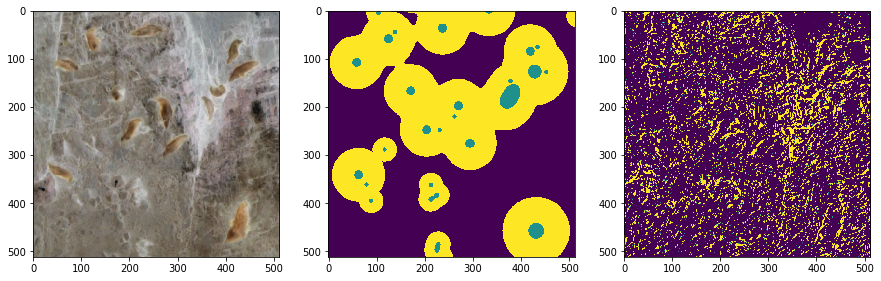

In [30]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(batch_y[i,..., 0])
plt.subplot(133)
plt.imshow(bpred[i,..., 0])

In [31]:
classes_counts = trainPatchesGenerator.compute_class_distribution(100)

In [32]:
classes_counts

[179644321, 3203767, 26867112]

In [33]:
179644321/3203767

56.0728420637331

In [34]:
weight_fg = 56.0728420637331
weight_bg = 1

In [35]:
def weighted_binary_crossentropy_ignore(y_true, y_pred):
    """ ypred: b, h, w, 1, value between 0 and 1
        ytrue: b, h, w, 1, value 0, 1 or 2
    """
    mask_bg = K.cast(K.equal(y_true, 0), K.floatx())
    mask_fg = K.cast(K.equal(y_true, 1), K.floatx())
    weights = (mask_fg * weight_fg + mask_bg * weight_bg)
    loss_per_pixel = K.binary_crossentropy(y_true, y_pred)
    loss_weighted = loss_per_pixel * weights
    sum_weights = K.sum(weights)
    sum_loss = K.sum(loss_weighted)
    return sum_loss/sum_weights

In [36]:
y_true = K.constant(np.random.randint(0, 3, (1, 512, 512, 1)))
y_pred = K.constant(np.random.randint(0, 3, (1, 512, 512, 1)))

In [37]:
with sess.as_default():
    print(weighted_binary_crossentropy_ignore(y_true, y_pred).eval())

0.273497


In [38]:
cb_checkpoint = ModelCheckpoint("/home/lowik/data/models/segmentation_ign/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/lowik/data/models/segmentation_ign/log_tb", batch_freq=10)

In [39]:
sgd = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=weighted_binary_crossentropy_ignore, metrics=["accuracy"])

In [ ]:
unet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=4, workers=1, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/20
